In [83]:
import numpy as np
import caiman as cm
import matplotlib.pyplot as plt
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf
from caiman.source_extraction.cnmf.params import CNMFParams
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour, view_quilt
import pandas as pd

# Source Extration for 2-Photon Calcium Imaging Data

In [ ]:
# Step 1: Motion Correction
# Step 2: Transform motion corrected memory map file into format suitable for cnmf method
# Step 3: Select spatial parameters
# Step 4: Fit cnmf model
# Step 5: Refit cnmf model
# Step 6: Explore the estimates class

## Preparing data for Source Extraction

In [3]:
# loading data
fname = "../data/Sue_2x_3000_40_-46.tif"
movie_orig = cm.load(fname)

In [11]:
# motion correction
params = CNMFParams()
params.motion

{'border_nan': 'copy',
 'gSig_filt': None,
 'is3D': False,
 'max_deviation_rigid': 3,
 'max_shifts': (6, 6),
 'min_mov': None,
 'niter_rig': 1,
 'nonneg_movie': True,
 'num_frames_split': 80,
 'num_splits_to_process_els': None,
 'num_splits_to_process_rig': None,
 'overlaps': (32, 32),
 'pw_rigid': False,
 'shifts_opencv': True,
 'splits_els': 14,
 'splits_rig': 14,
 'strides': (96, 96),
 'upsample_factor_grid': 4,
 'use_cuda': False,
 'indices': (slice(None, None, None), slice(None, None, None))}

In [13]:
motion_params = {
    'strides': (48, 48),
    'overlaps': (24, 24),
    'max_shifts': (6, 6),
    'max_deviation_rigid': 3,
    'pw_rigid': True
}
params.motion.update(motion_params)
mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)
mc.fname_tot_els

['../data\\Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap']

In [19]:
# loading and prepping motion corrected file
mc_fname = cm.save_memmap(
    mc.fname_tot_els,
    base_name='memmap_',
    order='C'
)
Yr, dims, num_frames = cm.load_memmap(mc_fname)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F')
images.shape

(3000, 170, 170)

## Setting Parameters for Source Extraction and Motion Correction for 2p 

In [22]:
params.patch

{'border_pix': 0,
 'del_duplicates': False,
 'in_memory': True,
 'low_rank_background': True,
 'memory_fact': 1,
 'n_processes': 1,
 'nb_patch': 1,
 'only_init': True,
 'p_patch': 0,
 'remove_very_bad_comps': False,
 'rf': None,
 'skip_refinement': False,
 'p_ssub': 2,
 'stride': None,
 'p_tsub': 2}

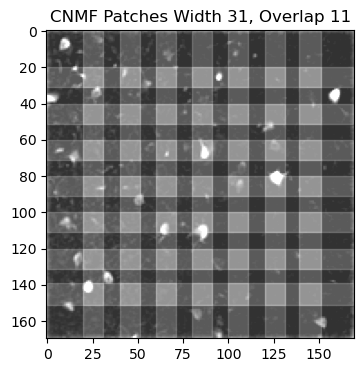

In [45]:
patch_params = {
    "rf": 15,
    "stride": 10
}
params.patch.update(patch_params)
cnmf_model = cnmf.CNMF(n_processes=1, params=params)

cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap

correlation_image = cm.local_correlations(images, swap_dim=False)

patch_ax = view_quilt(correlation_image, 
                      cnmf_patch_stride, 
                      cnmf_patch_overlap, 
                      vmin=np.percentile(np.ravel(correlation_image),50), 
                      vmax=np.percentile(np.ravel(correlation_image),99.5),
                      figsize=(4,4));
patch_ax.set_title(f'CNMF Patches Width {cnmf_patch_width}, Overlap {cnmf_patch_overlap}');

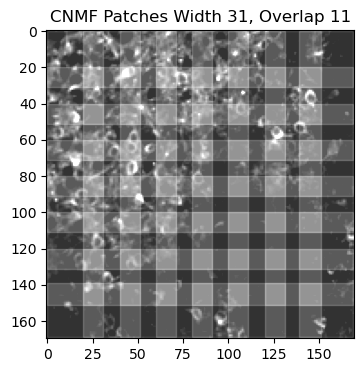

In [51]:
patch_params = {
    "rf": 15,
    "stride": 10
}
params.patch.update(patch_params)
cnmf_model = cnmf.CNMF(n_processes=1, params=params)

cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap

med_image = np.median(images, axis=0)

patch_ax = view_quilt(med_image, 
                      cnmf_patch_stride, 
                      cnmf_patch_overlap, 
                      vmin=np.percentile(np.ravel(med_image),50), 
                      vmax=np.percentile(np.ravel(med_image),99.5),
                      figsize=(4,4));
patch_ax.set_title(f'CNMF Patches Width {cnmf_patch_width}, Overlap {cnmf_patch_overlap}');

In [54]:
# gSig should be half the average of the width of neurons: 4
# number of neurons in densest patch: 7

In [61]:
params.change_params(
    {'gSig': 4,
     'K': 7
    }
)
cnmf_model = cnmf.CNMF(n_processes=1, params=params)

## CNMF for Source Extraction

In [62]:
cnmf_fit = cnmf_model.fit(images=images)

c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

In [66]:
cnmf_fit.estimates.plot_contours_nb(img=med_image)

In [64]:
# refitting
cnmf_refit = cnmf_fit.refit(images)

In [65]:
cnmf_refit.estimates.plot_contours_nb(img=med_image);

## Exploring the Estimates Class

In [75]:
cnmf_fit.estimates.C.shape, cnmf_refit.estimates.C.shape

((292, 3000), (291, 3000))

In [73]:
cnmf_fit.estimates.S.shape, cnmf_refit.estimates.S.shape

((292, 3000), (291, 3000))

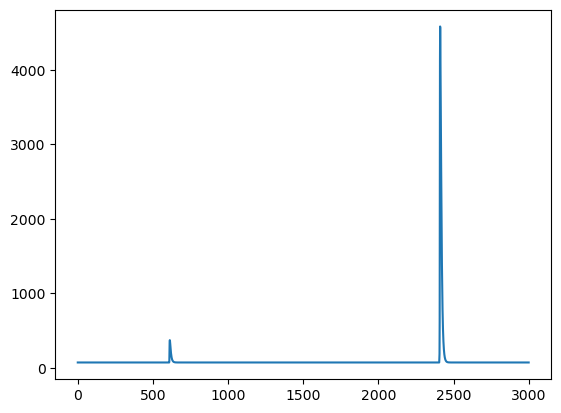

In [81]:
plt.plot(cnmf_fit.estimates.C[0])

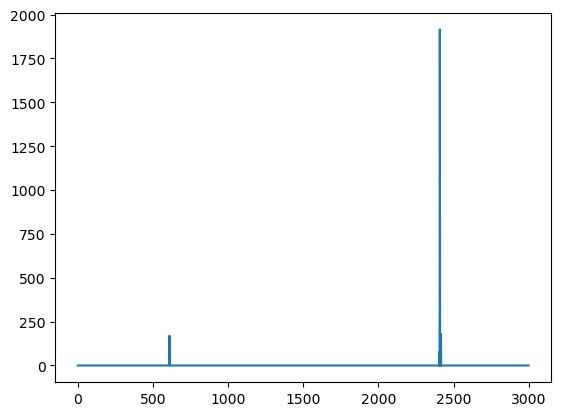

In [82]:
plt.plot(cnmf_fit.estimates.S[0])

In [97]:
frame_rate = cnmf_refit.params.data['fr']
frame_pd = 1/frame_rate
frame_times = np.linspace(0, num_frames*frame_pd, num_frames);

data_to_save = np.vstack((frame_times, cnmf_refit.estimates.S)).T  # Transpose so time series are in columns
save_df = pd.DataFrame(data_to_save)
save_df.rename(columns={0:'time'}, inplace=True)
save_df.head()


,time,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,45.875892,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.585596,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.043699,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,51.303192,0.0,0.000000,0.0
1,0.033344,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,11.321235,0.0,0.0,0.0,0.0,0.0,0.0,34.045301,0.0,0.0,0.0,0.0,0.0,15.532311,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.999878,0.0,0.0,0.0,0.0,49.391507,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.185582,0.0,0.0,0.0,0.0,19.466336,0.0,0.0,0.0,0.0,0.0,0.000000,63.822742,0.0,72.870868,0.0
2,0.066689,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,66.442718,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,19.858344,0.000000,0.0,148.993516,0.0
3,0.100033,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.260080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,71.356926,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,249.147552,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,11.275493,0.0,0.0,0.0,0.0,0.0,28.575241,49.776763,0.0,214.585807,0.0
4,0.133378,0.0,0.0,17.065929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.419977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.918975,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,259.427245,0.0,0.0,0.0,18.152386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.184834,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


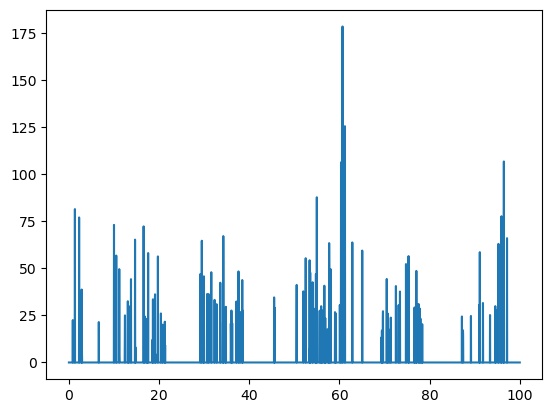

In [98]:
plt.plot(save_df.time, save_df[6])